# クラウドソーシング結果の整理 (AMT2回目)

目的：

    1. クラウドソーシングの結果を整理し，機械学習可能なデータにしておく．
    2. クラウドソーシングの結果を分析し，評価を行う．

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import japanize_matplotlib

In [2]:
df = pd.read_csv("results/Batch_4762707_batch_results.csv")

In [3]:
df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.image_url',
       'Answer.face impressions.labels', 'Approve', 'Reject'],
      dtype='object')

In [4]:
df[0:3]

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.image_url,Answer.face impressions.labels,Approve,Reject
0,3087LXLJ6NJLMW4A4OO0OO2IO4VF0M,35EE6WR8LH5R4JJ5CG05YH113AV714,Select applicable face impressions.,Please identify ALL applicable face impression...,"categorize, image",$0.02,Thu Jun 16 21:26:21 PDT 2022,1,BatchId:4762707;OriginalHitTemplateId:928390873;,300,...,NaN,NaN,29,100% (79/79),100% (23/23),100% (23/23),https://www.u.tsukuba.ac.jp/~s*******/mast-ai-...,"[""Sociable""]",NaN,NaN
1,30IRMPJWD0MK2CGNZCYCOXVA5QCRKZ,35EE6WR8LH5R4JJ5CG05YH113AV714,Select applicable face impressions.,Please identify ALL applicable face impression...,"categorize, image",$0.02,Thu Jun 16 21:26:20 PDT 2022,1,BatchId:4762707;OriginalHitTemplateId:928390873;,300,...,NaN,NaN,19,100% (1/1),100% (1/1),100% (1/1),https://www.u.tsukuba.ac.jp/~s*******/mast-ai-...,"[""Caring"",""Confident"",""Intelligent"",""Sociable""]",NaN,NaN
2,30Y6N4AHYQZCO6AD7VCPKK0KLHFRDM,35EE6WR8LH5R4JJ5CG05YH113AV714,Select applicable face impressions.,Please identify ALL applicable face impression...,"categorize, image",$0.02,Thu Jun 16 21:26:14 PDT 2022,1,BatchId:4762707;OriginalHitTemplateId:928390873;,300,...,NaN,NaN,93,100% (40/40),100% (19/19),100% (15/15),https://www.u.tsukuba.ac.jp/~s*******/mast-ai-...,"[""Confident"",""Caring"",""Emotionally stable"",""Re...",NaN,NaN


## 結果の分析

### ワーカーあたり回答数の分布

In [5]:
from collections import OrderedDict

In [6]:
counts = OrderedDict()

In [7]:
for record in df["WorkerId"]:
    if record in counts.keys():
        counts[record] += 1
    else:
        counts[record] = 1

In [8]:
counts_sorted = OrderedDict(
    sorted(counts.items(), key=lambda x: x[1], reverse=True)
)

In [9]:
left = np.arange(1,len(counts.keys())+1)
height = np.array(list(counts_sorted.values()))
ratio = np.zeros(len(left))
total_sum = 0
for i,v  in enumerate(height):
    total_sum += v
    ratio[i] = total_sum / 255 * 100

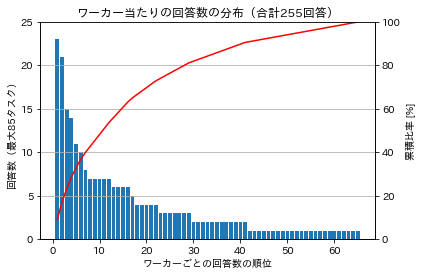

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(left, height)
ax.set_title("ワーカー当たりの回答数の分布（合計255回答）")
ax.set_xlabel("ワーカーごとの回答数の順位")
ax.set_ylabel("回答数（最大85タスク）")

ax_add = ax.twinx()
ax_add.plot(left, ratio, color="red")
ax_add.set_ylim([0, 100])
ax_add.set_ylabel("累積比率 [%]")

plt.grid()
ax.set_ylim([0,25])
plt.plot() ;

全体の1/6のワーカーが約半分を解いていることになる

## データ整理<s>とアグリゲーション</s>

In [11]:
labels = dict()
labels["Caring"] = 0
labels["Confident"] = 1
labels["Emotionally stable"] = 2
labels["Intelligent"] = 3
labels["Responsible"] = 4
labels["Sociable"] = 5
labels["Trustworthy"] = 6

In [12]:
class task:
    def __init__(self, image_id):
        self.image_id = image_id
        self.answers = []

In [13]:
tasks = dict()

In [14]:
for url, ans in zip(df["Input.image_url"], df["Answer.face impressions.labels"]):
    img_id = url[50:-4]
    if not img_id in tasks.keys():
        tasks[img_id] = task(img_id)
    
    ans_trimed = ans[1:-2].replace("\"","")
    ans_list = ans_trimed.split(",")
    ones = [labels[a] for a in ans_list]
    bits = np.zeros(7)
    for i in ones:
        bits[i] = 1
    
    tasks[img_id].answers.append(bits)

In [15]:
tasklist = list(tasks.values())

In [18]:
for t in tasklist:
    sumbit = np.zeros(7)
    for ans in t.answers:
        sumbit += ans
    agree = np.zeros(7)
    agree[np.where(sumbit >= 1)] = 1
    t.smv = agree # Simple majority vote

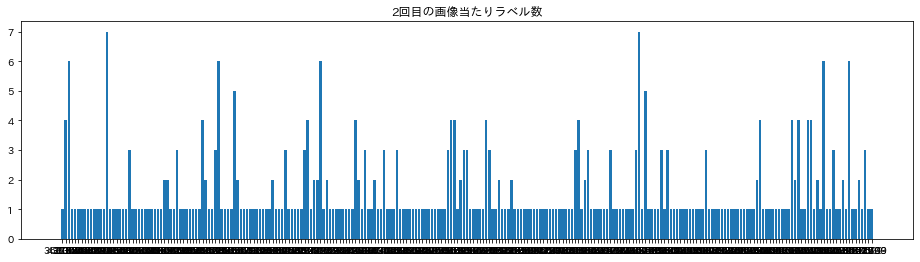

In [22]:
label_num = []
for t in tasks.items():
    label_num.append(t[1].smv.sum())
    
plt.figure(figsize=(16,4))
plt.title("2回目の画像当たりラベル数")
plt.bar(tasks.keys(), label_num)
plt.plot() ;

## ラベルの分布

単純多数決

In [23]:
sums = np.zeros(7)
for t in tasklist:
    sums += t.smv

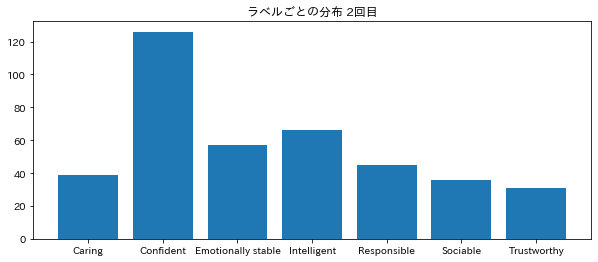

In [25]:
plt.figure(figsize=(10,4))
plt.title("ラベルごとの分布 2回目")
plt.bar(labels.keys(), sums)
plt.plot() ;

# データを書き込む

- 1回目の単純多数決と結合する

In [28]:
records = []  
for t in tasklist:
    record = [t.image_id]
    record.extend(t.smv)
    records.append(record)

In [29]:
cols = ["Id"]
cols.extend(labels.keys())
csv = pd.DataFrame(records, columns=cols)

In [30]:
csv

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,368079,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,438384,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,30155,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,270812,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,330524,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
250,35629,1.0,1.0,0.0,0.0,0.0,0.0,0.0
251,312270,0.0,1.0,0.0,0.0,0.0,0.0,0.0
252,127529,1.0,1.0,1.0,0.0,0.0,0.0,0.0
253,394899,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_smv = pd.read_csv("../data1.csv")

In [32]:
df_smv

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,272998,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,124821,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
mdf = pd.concat([df_smv, csv])

In [36]:
mdf

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,272998,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
250,35629,1.0,1.0,0.0,0.0,0.0,0.0,0.0
251,312270,0.0,1.0,0.0,0.0,0.0,0.0,0.0
252,127529,1.0,1.0,1.0,0.0,0.0,0.0,0.0
253,394899,0.0,1.0,0.0,0.0,0.0,0.0,0.0


C:\Users\Owner\AppData\Local\Temp\ipykernel_9328\2010575429.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(labels.keys(), mdf.sum())


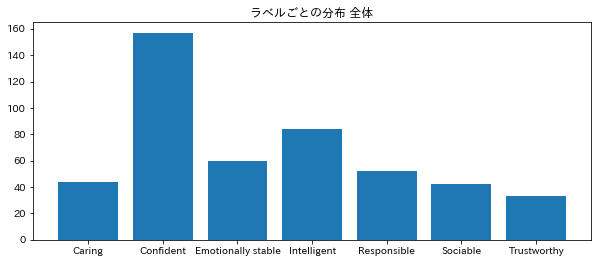

In [43]:
plt.figure(figsize=(10,4))
plt.title("ラベルごとの分布 全体")
plt.bar(labels.keys(), mdf.sum())
plt.plot() ;

In [44]:
csv.to_csv("../data_merged.csv", index=None)